In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import coordinates as coords
from astroquery.simbad import Simbad
import astroquery

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import gwb

In [6]:
tgas = gwb.TGASData("/Users/semyeong/data/gaia/tgas_source/stacked_tgas.fits")

In [7]:
df = pd.read_csv("../data/targets.csv")
print(len(df))

45


In [8]:
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype')
customSimbad.add_votable_fields('orv')
customSimbad.add_votable_fields('bibcodelist(1850-2017)')

In [9]:
for field in ['rv_value', 'rvel', 'gcrv', 'orv']:
    customSimbad.get_field_description(field)

Radial velocity value. Eventually translated from a redshift
Radial velocities of galaxies
General Catalogue of Radial Velocities
oRV stellar radial velocities (will shortly replace 
              the GCRV measurements.


In [10]:
result = customSimbad.query_objects(df.hip_tyc_id)

In [18]:
result['MAIN_ID', 'oRV_RVel',
 'oRV_Q',
 'oRV_Nmes',
 'oRV_Rem',
 'oRV_Orig',
 'oRV_Dis',
 'oRV_bibcode',][~result['oRV_RVel'].mask]

MAIN_ID,oRV_RVel,oRV_Q,oRV_Nmes,oRV_Rem,oRV_Orig,oRV_Dis,oRV_bibcode
,km / s,,,,,a / mm,
object,float32,str1,int32,object,str2,int32,str19
HR 5345,-15.0,C,4,,##,0,1953GCRV..C......0W
HD 133909,-9.0,D,6,,##,0,1953GCRV..C......0W
HR 5280,-9.5,C,10,,##,0,1979IAUS...30...57E
* 81 UMa,-7.0,D,25,,##,0,1979IAUS...30...57E
HD 124370,4.0,C,2,,##,0,1953GCRV..C......0W
* 84 UMa,-1.8,B,47,,##,0,1979IAUS...30...57E
HR 5372,-3.2,B,4,,##,0,1953GCRV..C......0W
HR 5169,-6.5,C,10,,##,0,1979IAUS...30...57E


In [17]:
result['oRV_RVel'][~result['oRV_RVel'].mask]

-15.0
-9.0
-9.5
-7.0
4.0
-1.8
-3.2
-6.5


In [19]:
import sys
sys.path.append('../../gaia-wide-binaries/notebooks/')
import tap

class SimbadTAP(tap.TAP_Service):
    def __init__(self, *args, **kwargs):
        host = "simbad.u-strasbg.fr"
        port = 80
        path = "/simbad/sim-tap"
        tap.TAP_Service.__init__(self, host, path, port, *args, **kwargs)

In [18]:
query_template = """
SELECT BIBCode,
       Journal,
       Title,
       Year,
       Volume,
       DOI
FROM ref JOIN has_ref ON oidbibref = oidbib JOIN ident ON has_ref.oidref = ident.oidref
WHERE id = '{}'
ORDER BY Year DESC;
"""

In [20]:
mytap = SimbadTAP()

In [31]:
tablelist = mytap.get_table_list()

In [39]:
list(filter(lambda x: 'mes' in x, [x.decode() for x in tablelist['table_name']]))

['mesCEL',
 'mesClg',
 'mesDistance',
 'mesDiameter',
 'mesEinstein',
 'mesFe_h',
 'mesGcrv',
 'mesGen',
 'mesGJ',
 'mesHbet',
 'mesHgamma',
 'mesIRAS',
 'mesIRC',
 'mesISO',
 'mesIUE',
 'mesJP11',
 'mesMK',
 'mesPLX',
 'mesPM',
 'mespos',
 'mesposa',
 'mesRot',
 'mesSao',
 'mesTD1',
 'mesUBV',
 'mesUVBY',
 'mesVar',
 'mesVelocities',
 'mesXmm']

* possibly relevant tables for RV:
    - mesGcrv
    - mesVelocities

In [65]:
for col in mytap.get_table_info('ident').itercols():
    print(col.name, col.dtype, col.description)

id object Identifier
oidref int64 Object internal identifier


In [61]:
for col in mytap.get_table_info('mesGcrv').itercols():
    print(col.name, col.dtype, col.description)

bibcode object measurement bibcode
dispersion int16 Dispersion
mespos int16 Position of a measurement in a list of measurements
nbmes int16 Number of measurements
obscode object Observatory code
oidref int64 Object internal identifier
qual |S1 Quality
radvel float32 Radial velocity
radvel_prec int16 Precision (# of decimal positions) associated with the column radvel
remarks object Remarks


I get nothing from `mesGcrc` table for some reason.
Query used:

```
query_rvmes = """
SELECT qual,
       radvel,
       radvel_prec,
       remarks,
       ident.oidref
FROM mesGcrv JOIN ident ON mesGcrv.oidref = ident.oidref
WHERE id = 'HD 120198'
"""
```

In [62]:
for col in mytap.get_table_info('mesVelocities').itercols():
    print(col.name, col.dtype, col.description)

bibcode object measurement bibcode
d |S1 'D' if the resolution is a conversion from the dispersion
meanError float32 sigma(Value)
meanError_prec int16 Precision (# of decimal positions) associated with the column meanError
mespos int16 Position of a measurement in a list of measurements
nature object nature of the measurement
nbmes int16 Number of measurements
obsdate float64 Observation date
obsdate_prec int16 Precision (# of decimal positions) associated with the column obsdate
oidref int64 Object internal identifier
origin object Origin of the radial velocity
qual |S1 Quality
quality |S1 Quality
remark |S1 colon is uncertain question mark is questionable
remarks object Remarks
resolution int32 Resolution
velType object velocity type (v, z or cz)
velValue float64 Velocity
velValue_prec int16 Precision (# of decimal positions) associated with the column velValue
wdomain object Wavelength domain (Rad,mm,IR,Opt,UV,XRay,Gam)


In [114]:
query_rvmes = """
SELECT bibcode, nbmes, obsdate, qual, quality, velType, velValue, velValue_prec, remark, remarks, ident.oidref
FROM mesVelocities JOIN ident ON mesVelocities.oidref = ident.oidref
WHERE id = '{}'
"""

In [123]:
result[['MAIN_ID']][~result['oRV_RVel'].mask].write("testupload.vot", format='votable')

In [135]:
import time

In [136]:
outtables = []
for iden in df.hip_tyc_id:
    try:
        tmp = mytap.query(query_rvmes.format(iden))
        print(iden, len(tmp))
        if len(tmp) != 0:
            tmp['hip_tyc_id'] = [iden]*len(tmp)
            outtables.append(tmp)
        time.sleep(.1)
    except Exception as e:
        print(e)

TYC 4164-274-1 0
TYC 3471-333-1 0
TYC 3480-1209-1 0
HIP 69650 3
TYC 3489-1148-1 0
TYC 3470-485-1 0
TYC 3851-336-1 0
TYC 3868-177-1 0
TYC 3867-127-1 0
HIP 72389 0
TYC 3851-369-1 0
TYC 3490-1083-1 0
HIP 73730 3
TYC 3471-233-1 0
TYC 3486-1405-1 0
TYC 3860-1483-1 0
TYC 3877-725-1 0
HIP 71911 1
TYC 4174-1117-1 0
TYC 4173-609-1 0
HIP 74458 1
TYC 3867-1373-1 0
TYC 3867-281-1 0
HIP 68637 5
TYC 3875-762-1 0
TYC 3850-257-1 0
HIP 63702 0
TYC 4180-573-1 0
HIP 66198 7
HIP 69275 3
HIP 75449 0
TYC 3851-600-1 0
TYC 3861-1374-1 0
TYC 3865-934-1 0
HIP 67231 7
HIP 69917 1
HIP 78958 1
TYC 3869-656-1 0
HIP 69958 3
HIP 77903 0
TYC 3496-1082-1 0
TYC 3497-1053-1 0
TYC 3867-2-1 0
HIP 67005 5
HIP 69721 0


In [139]:
dfrvmes = atable.vstack(outtables).to_pandas()

In [217]:
dfrvmes.loc[dfrvmes.oidref == 458282]

,bibcode,nbmes,obsdate,qual,quality,velType,velValue,velValue_prec,remark,remarks,oidref,hip_tyc_id
6,b'2006AstL...32..759G',NaN,NaN,b'',b'B',b'V ',-26.0,2.0,b'',b'',458282.0,HIP 71911


In [159]:
dfrvmes_mr = pd.DataFrame()

for i, g in dfrvmes.groupby("hip_tyc_id"):
    # take the most recent
    dfrvmes_mr = pd.concat([dfrvmes_mr, g.sort_values("bibcode").iloc[[-1]]])

In [162]:
df_hasrv = pd.merge(dfrvmes_mr[['hip_tyc_id', 'velValue']], df, how='left')

In [211]:
dfrvmes_mr

,bibcode,nbmes,obsdate,qual,quality,velType,velValue,velValue_prec,remark,remarks,oidref,hip_tyc_id
19,b'2007AN....328..889K',NaN,NaN,b'',b'D',b'V ',-7.0,2.0,b'',b'',529578.0,HIP 66198
39,b'2006AstL...32..759G',NaN,NaN,b'',b'B',b'V ',-12.3,2.0,b'',b'',547216.0,HIP 67005
29,b'2006AstL...32..759G',NaN,NaN,b'',b'B',b'V ',-2.4,2.0,b'',b'',529163.0,HIP 67231
12,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',-9.5,2.0,b'',b'',546419.0,HIP 68637
22,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',4.0,2.0,b'',b'',459297.0,HIP 69275
2,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',-16.9,2.0,b'',b'',517283.0,HIP 69650
30,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',-10.0,2.0,b'',b'',517301.0,HIP 69917
34,b'2007AN....328..889K',NaN,NaN,b'',b'B',b'V ',-3.2,2.0,b'',b'',499545.0,HIP 69958
6,b'2006AstL...32..759G',NaN,NaN,b'',b'B',b'V ',-26.0,2.0,b'',b'',458282.0,HIP 71911
5,b'2007AN....328..889K',NaN,NaN,b'',b'D',b'V ',-9.0,2.0,b'',b'',444232.0,HIP 73730


In [164]:
import numpy as np

In [314]:
df[['tgas_ra', 'tgas_dec']].values

array([[ 204.86346089,   61.06172697],
       [ 210.58975157,   52.41774134],
       [ 223.27003558,   51.26115172],
       [ 213.82069561,   52.53590899],
       [ 234.45997416,   51.53768342],
       [ 206.31848758,   52.24726328],
       [ 205.40212412,   53.33750797],
       [ 230.81617834,   54.84822589],
       [ 225.82013999,   59.01151843],
       [ 222.01172646,   56.15919916],
       [ 205.78236011,   54.02590356],
       [ 237.50529661,   45.92062512],
       [ 226.07328062,   59.535053  ],
       [ 211.95506872,   51.95266127],
       [ 234.1347255 ,   48.27970243],
       [ 219.85979707,   54.77405567],
       [ 240.27846387,   53.41639716],
       [ 220.63149435,   60.23096098],
       [ 209.67122784,   63.68876516],
       [ 219.82001843,   61.93125707],
       [ 228.24117545,   56.04643239],
       [ 222.87594816,   59.5320803 ],
       [ 226.10717529,   59.88078262],
       [ 210.74889171,   50.97178452],
       [ 231.92341119,   59.98703931],
       [ 201.21590416,   

In [166]:
# matrix that projects vxyz to vra,vdec
M_data = np.array(
    [[[-np.sin(rr), np.cos(rr), 0.],
     [-np.sin(dd)*np.cos(rr), -np.sin(dd)*np.sin(rr), np.cos(dd)],
     [np.cos(dd)*np.cos(rr), np.cos(dd)*np.sin(rr), np.sin()]]
     for rr, dd in zip(np.deg2rad(df_hasrv.tgas_ra), np.deg2rad(df_hasrv.tgas_dec))])
print(M_data.shape)

(12, 3, 3)


In [177]:
radecr2xyz =  np.transpose(M_data, (0,2,1))

In [207]:
vradecr = np.array(
    [[tgas[a.tgas_row].pmra.value*a.tgas_distance/1e3*4.74,
      tgas[a.tgas_row].pmdec.value*a.tgas_distance/1e3*4.74, a.velValue]
     for a in df_hasrv.itertuples()])

In [239]:
vradecr[vradecr[:,2].argsort()]

array([[ -8.18059978,  -1.93503272, -26.        ],
       [ -7.22631716,  -0.65301123, -21.6       ],
       [ -8.04449184,  -1.58749227, -16.9       ],
       [ -8.09518517,  -2.48335373, -12.3       ],
       [ -8.12556803,  -1.47523136, -10.        ],
       [ -7.9012235 ,  -2.98380045,  -9.5       ],
       [ -7.46565793,  -1.4082957 ,  -9.1       ],
       [ -7.22175773,  -0.08693238,  -9.        ],
       [ -8.54678487,  -2.71926304,  -7.        ],
       [ -8.18194305,  -1.01903777,  -3.2       ],
       [ -8.58348106,  -2.20011277,  -2.4       ],
       [ -8.42983368,  -1.48992401,   4.        ]])

In [237]:
vradecr.mean(axis=0), vradecr.std(axis=0)

(array([ -8.00023698,  -1.67012395, -10.25      ]),
 array([ 0.4487233 ,  0.81392109,  7.92553889]))

In [198]:
import corner

In [200]:
corner.hist2d??

In [234]:
vradecr_t = np.array([[-8, -1.5, rv] for rv in np.linspace(-50,50,100)])
vxyz_t = np.einsum("ijk,ik->ij", np.array([radecr2xyz[0]]*100), vradecr_t)

In [223]:
np.einsum("ijk,ik->ij", radecr2xyz, vradecr)

array([[ -1.81395253,   8.53204042,  -7.30450448],
       [  1.49106495,   9.73157823, -11.2277415 ],
       [ -4.20166267,   7.49514153,  -3.23195414],
       [ -0.89058891,   8.66388773,  -9.25884975],
       [ -7.22155308,   5.37997224,   2.86130028],
       [  3.0158176 ,  11.70351039, -14.3797312 ],
       [ -0.51234912,   9.5211629 ,  -8.79125241],
       [ -3.83301422,   7.29855456,  -3.20339404],
       [  3.19504814,  13.52089301, -23.52963417],
       [ -2.08769687,   8.24251018,  -7.80153124],
       [  2.28336224,  13.40788029, -18.28171453],
       [ -4.2637122 ,   7.84394173,  -7.79888976]])

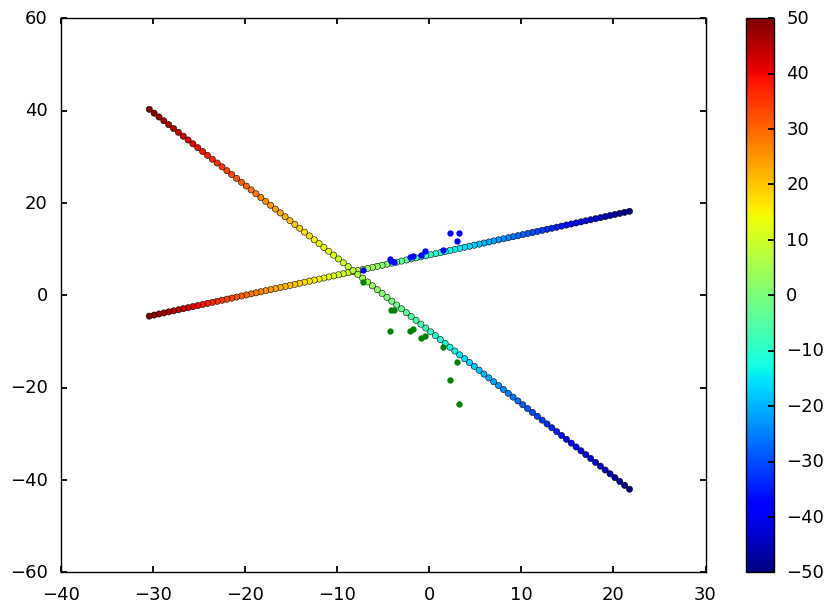

In [236]:
vx,vy,vz = np.einsum("ijk,ik->ij", radecr2xyz, vradecr).T
plt.plot(vx, vy, '.');
plt.plot(vx, vz, '.');
plt.scatter(vxyz_t[:,0], vxyz_t[:,1], c=np.linspace(-50,50,100));
plt.scatter(vxyz_t[:,0], vxyz_t[:,2], c=np.linspace(-50,50,100));
plt.colorbar()
# plt.xlim(-20,20);
# plt.ylim(-20,20);

In [243]:
dfstar = pd.read_csv("../../gaia-wide-binaries/db/table_star_new.csv")

In [268]:
ple = atable.Table.read("../data/webda_pleiades_radec.txt", format='ascii.no_header')

In [275]:
ple['ra'] = [" ".join([str(x) for x in a]) for a in ple['col3','col4','col5']]
ple['dec'] = [" ".join([str(x) for x in a]) for a in ple['col6','col7','col8']]

In [279]:
c = coords.SkyCoord(ple["ra"], ple["dec"], unit=(u.hourangle, u.deg))

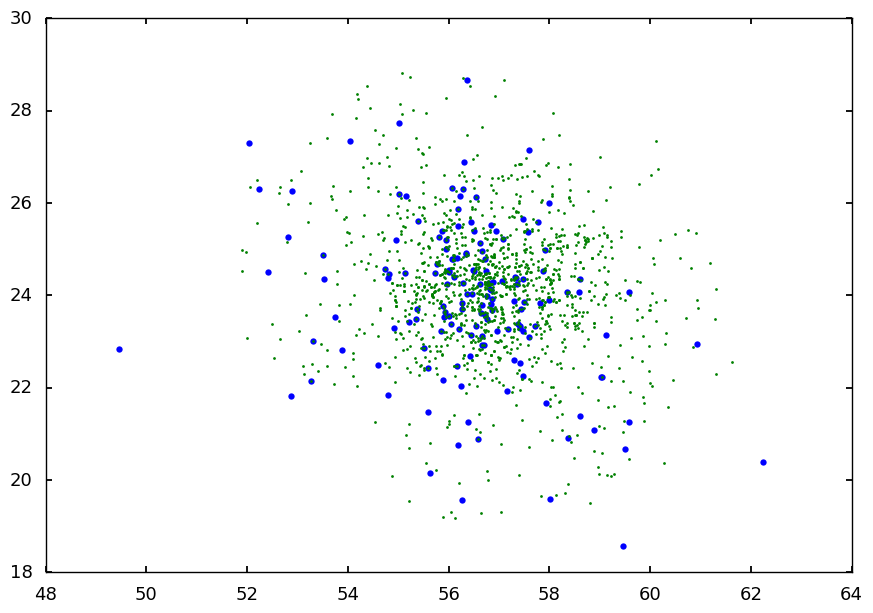

In [290]:
df0 = dfstar.loc[dfstar.group_id==0]
plt.plot(df0.tgas_ra, df0.tgas_dec,'.');

plt.plot(c.ra, c.dec, '.', ms=4);

In [295]:
!ls ../../gaia-wide-binaries/data

Faherty-Bochanski-Matches.txt      isochrone_pleiades_unique.txt
Faherty-Bochanski-Matches_tgas.txt mwsc
J_A+A_585_A101                     oldvprior
J_AJ_117_354                       other
J_AJ_117_354.tar.gz                pleiades_simbad.votable
RAVE_DR5.csv                       s_oh_clusters_ids.txt
RAVE_DR5.csv.gz                    single?name=DR5%2FRAVE_DR5.fits.gz
RAVE_DR5.fits                      snr8_dv10_llr7.5.fits
RAVE_RAVEon_TGAS.pkl               snr8_n64_dv8_vscatter0-lratio.h5
RAVE_TGAS.csv                      stacked_tgas.fits
RAVE_TGAS.csv.gz                   tgas_apogee_deduplicated_2as.fits
apj497776t1_ascii.txt              tgas_pmshuffle.fits
catdl?name=dr2.fits.gz             tgas_rave_RV.fits
control_singles.txt                tgas_ravedr5.fits
heasarc_mwsc.txt                   tgas_tmass_wise.fits
incomplete                         tgas_tmass_wise.vot
isochrone_pairidx_mutexc.fits      tgas_tmassj.fits
isochrone_pairidx_mutexc.txt       tim-binaries-1.fi

In [298]:
tgasrave=atable.Table.read("../../gaia-wide-binaries/data/tgas_rave_RV.fits")

In [312]:
tgasrave[dfstar.loc[dfstar.group_id==0, 'tgas_row'].values].show_in_browser()

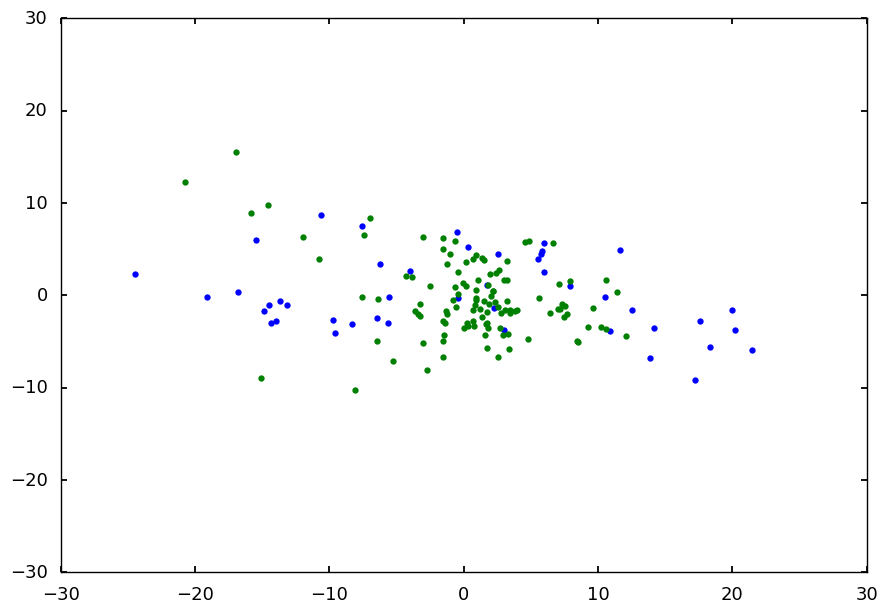

In [294]:
plt.plot(df.tgas_ra-df.tgas_ra.mean(), df.tgas_dec-df.tgas_dec.mean(),'.');

df0 = dfstar.loc[dfstar.group_id==2]
plt.plot(df0.tgas_ra-df0.tgas_ra.mean(), df0.tgas_dec-df0.tgas_dec.mean(),'.');


plt.xlim(-30,30);
plt.ylim(-30,30);

In [192]:
vxyz.shape

(12, 3, 12)

In [ ]:
xx = np.array([[a.]])

In [144]:
pd.concat([dfrvmes_mr, dfrvmes])

,bibcode,nbmes,obsdate,qual,quality,velType,velValue,velValue_prec,remark,remarks,oidref,hip_tyc_id
0,b'1937PDAO....7....1H',4.0,NaN,b'',b'',b'v ',-16.0,1.0,b'',b'',517283.0,HIP 69650
1,b'1953GCRV..C......0W',4.0,NaN,b'',b'C',b'v ',-15.0,0.0,b'',b'##',517283.0,HIP 69650
2,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',-16.9,2.0,b'',b'',517283.0,HIP 69650
3,b'1939PDDO....1...71Y',6.0,NaN,b'',b'',b'v ',-9.6,1.0,b'',b'',444232.0,HIP 73730
4,b'1953GCRV..C......0W',6.0,NaN,b'',b'D',b'v ',-9.0,0.0,b'',b'##',444232.0,HIP 73730
5,b'2007AN....328..889K',NaN,NaN,b'',b'D',b'V ',-9.0,2.0,b'',b'',444232.0,HIP 73730
6,b'2006AstL...32..759G',NaN,NaN,b'',b'B',b'V ',-26.0,2.0,b'',b'',458282.0,HIP 71911
7,b'2006AstL...32..759G',NaN,NaN,b'',b'C',b'V ',-21.6,2.0,b'',b'',456725.0,HIP 74458
8,b'1945PDDO....1..311Y',5.0,NaN,b'',b'',b'v ',-8.7,1.0,b'',b'',546419.0,HIP 68637
9,b'1953GCRV..C......0W',5.0,NaN,b'',b'C',b'v ',-8.0,0.0,b'',b'##',546419.0,HIP 68637


In [120]:
outtables[1]

bibcode,nbmes,obsdate,qual,quality,velType,velValue,velValue_prec,remark,remarks,oidref
object,int16,float64,bytes1,bytes1,object,float64,int16,bytes1,object,int64
1939PDDO....1...71Y,6,--,,,v,-9.6000003814697266,1,,,444232
1953GCRV..C......0W,6,--,,D,v,-9.0,0,,##,444232
2007AN....328..889K,--,--,,D,V,-9.0,2,,,444232


In [111]:
import astropy.table as atable

In [116]:
atable.vstack(outtables).show_in_browser()

TypeError: 'module' object is not subscriptable

In [101]:
mytap.query(query_rvmes)

bibcode,nbmes,obsdate,qual,quality,velType,velValue,oidref
object,int16,float64,bytes1,bytes1,object,float64,int64
1921PDAO....2....1P,6,--,,,v,-5.3000001907348633,529163
1929ApJ....70..207A,5,--,,,v,-5.0,529163
1929PYerO...7....1F,6,--,,,v,-4.0,529163
1953GCRV..C......0W,17,--,,A,v,-4.9000000953674316,529163
1968RGOB..135..385P,30,--,,,v,0.0,529163
1979IAUS...30...57E,47,--,,B,v,-1.7999999523162842,529163
2006AstL...32..759G,--,--,,B,V,-2.3999999999999999,529163


In [117]:
mytap.get_table_info('ref')

bibcode,doi,journal,last_page,nbobject,oidbib,page,title,volume,year
object,object,object,int32,int32,int64,int32,object,int32,int16


In [21]:
import time

In [22]:
biblist = []
for iden in result['MAIN_ID']:
    print('searching for {}'.format(iden.decode()))
    biblist.append(mytap.query(query_template.format(iden.decode())))
    time.sleep(5)  ## seems that I'm violating some rate limit or something

searching for TYC 4164-274-1
searching for TYC 3851-600-1
searching for TYC 3867-1373-1
searching for TYC 3861-1374-1
searching for TYC 4173-609-1
searching for TYC 4174-1117-1
searching for HD 238351
searching for TYC 3877-725-1
searching for TYC 3860-1483-1
searching for TYC 3486-1405-1
searching for TYC 3471-233-1
searching for TYC 4180-573-1
searching for TYC 3869-656-1
searching for HD 234065
searching for TYC 3496-1082-1
searching for HD 238423
searching for TYC 3868-177-1
searching for HD 234061
searching for TYC 3470-485-1
searching for TYC 3489-1148-1
searching for TYC 3497-1053-1
searching for BD+51  1966
searching for TYC 3471-333-1
searching for TYC 3490-1083-1
searching for TYC 3875-762-1
searching for BD+60  1587
searching for BD+49  2434
searching for HD 113491
searching for BD+56  1762
searching for HD 125259
searching for HD 137589
searching for TYC 3867-2-1
searching for HD 135501
searching for NAME Stella Ludoviciana
searching for HD 145145
searching for HD 133909
se

In [23]:
# add which object's reference it is
for i, t in enumerate(biblist):
    t['hip_tyc_id'] = [df.hip_tyc_id[i] for j in range(len(t))]

In [32]:
from astropy import table

In [24]:
dfBib = pd.concat([t.to_pandas() for t in biblist])

In [40]:
print("total number of refs = {:d}".format(len(dfBib)))
print("total number of unique refs = {:d}".format(dfBib.bibcode.unique().size))
print("number of stars with refs = {:d} / {:d}".format(
        df.hip_tyc_id.size - dfBib.hip_tyc_id.unique().size, df.hip_tyc_id.size))

total number of refs = 389
total number of unique refs = 230
number of stars with refs = 25 / 45


In [30]:
dfBib.index = range(len(dfBib))  # re-index

In [32]:
dfBib.to_csv("../data/target_bib.csv", index=False)

In [45]:
df.columns

Index(['tgas_row', 'tgas_ra', 'tgas_dec', 'tgas_distance', 'gx', 'gy', 'gz',
       'tgas_glon', 'tgas_glat', 'tgas_gmag', 'hip', 'tyc', 'hip_tyc_id',
       'source_id', 'tmass_j'],
      dtype='object')

In [112]:
from astropy import table
table.Table({"title":dfBib[['hip_tyc_id', 'title', 'bibcode']]}).show_in_browser(jsviewer=True)

In [37]:
dfBib.hip_tyc_id.unique()

,bibcode,journal,title,year,volume,doi,hip_tyc_id
0,b'2009ApJS..181..444A',b'ApJS',b'X-ray-emitting stars identified from the ROS...,2009.0,181.0,b'10.1088/0067-0049/181/2/444',TYC 3850-257-1
1,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 63702
2,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',HIP 63702
3,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',TYC 4180-573-1
4,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',TYC 4180-573-1
5,b'1997PNAOJ...5....1Y',b'PNAOJ',b'The Tokyo PMC Catalog 90-93: Catalog of posi...,1997.0,5.0,b'',TYC 4180-573-1
6,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 66198
7,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',HIP 66198
8,b'2011MNRAS.411..435B',b'MNRAS',b'Bayesian inference of stellar parameters and...,2011.0,411.0,b'10.1111/j.1365-2966.2010.17699.x',HIP 66198
9,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 69275


In [47]:
import numpy as np

In [56]:
df['gj'] = df['tgas_gmag'] - df['tmass_j']
df['gMag'] = df['tgas_gmag'] - 5*(np.log10(df['tgas_distance'])-1)

In [162]:
from astropy.table import Table

In [168]:
parsec_2MASS = Table.read("../data/parsec_2MASSJHKs.dat",
                    format='ascii.commented_header', header_start=5)
parsec_Gaia = Table.read("../data/parsec_Gaia.dat",
                    format='ascii.commented_header', header_start=5)

In [170]:
print(len(parsec_2MASS), len(parsec_Gaia))

29427 29427


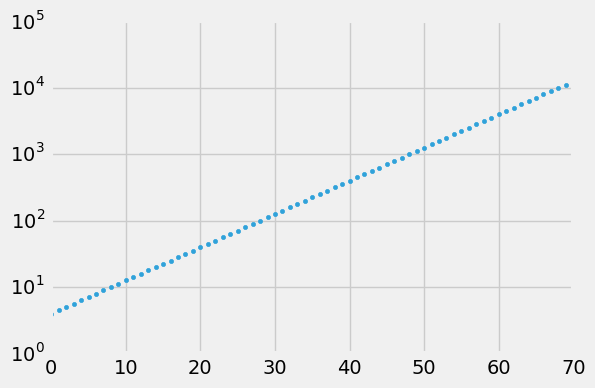

In [182]:
plt.plot(np.unique(parsec_2MASS['Age'])/1e6, '.')
plt.yscale('log')

In [187]:
ages = np.unique(parsec_2MASS['Age'])
print(len(ages))

71


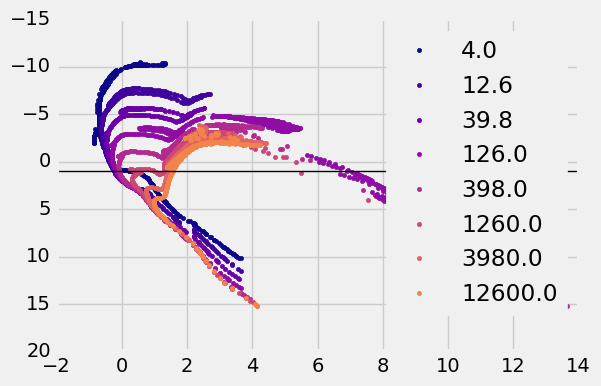

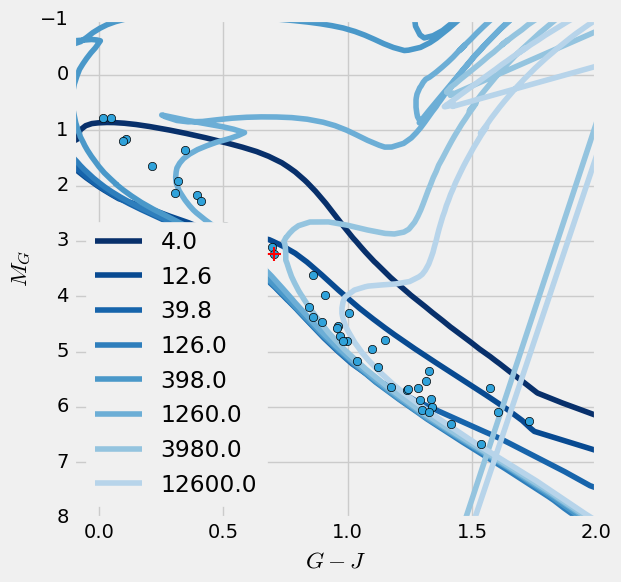

In [213]:
plt.figure(figsize=(6,6))

parsec_gj = parsec_Gaia['Gmag'] - parsec_2MASS['Jmag']
for i, age in enumerate(ages[::10]):
    cond = parsec_2MASS['Age']==age
    plt.plot(parsec_gj[cond], parsec_Gaia['Gmag'][cond], '-', color=plt.cm.Blues_r(i/10.),
             label='{:.1f}'.format(age/1e6))
#     plt.plot(parsec_gj[cond], parsec_2MASS['Jmag'][cond], '.', color=plt.cm.plasma(i/10.))

plt.legend(loc='lower left', numpoints=1)

plt.plot(df['gj'], df['gMag'], 'o')
plt.gca().invert_yaxis()
plt.xlabel('$G-J$')
plt.ylabel('$M_G$')
plt.xlim(-0.1,2)
plt.ylim(8,-1)
# for row in df.itertuples():
#     plt.text(row.gj, row.gMag, row.hip_tyc_id, rotation=45,
#              ha='left' if row.Index%2==0 else 'right',
#              va='bottom' if row.Index%2==0 else 'top')

select = df.loc[df.hip_tyc_id == 'HIP 69721']
plt.plot(select.gj, select.gMag, 'r+', ms=10, mew=1.5)

In [72]:
import sys
sys.path.append("../groupten/")

In [73]:
import read_mist_models

In [77]:
isocmd = read_mist_models.ISOCMD('../data/MIST_iso_1490194647.iso.cmd')

Reading in: ../data/MIST_iso_1490194647.iso.cmd


In [80]:
print('available columns: ', isocmd.hdr_list)

available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G', 'Gaia_BP', 'Gaia_RP', 'phase']


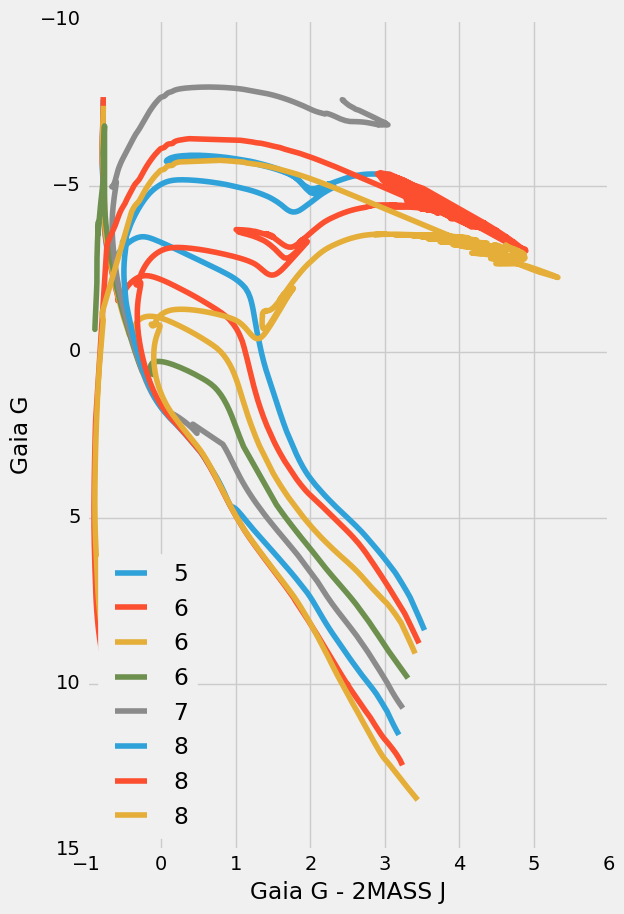

In [217]:
def plot_gjg(age):
    age_ind = isocmd.age_index(age) #returns the index for the desired age
    B = isocmd.isocmds[age_ind]['Gaia_G']
    V = isocmd.isocmds[age_ind]['2MASS_J']
    plt.plot(B-V, B, label='{:.0f}'.format(age))

plt.figure(figsize=(6,10))
plt.xlabel('Gaia G - 2MASS J')
plt.ylabel('Gaia G')
# plt.axis([-2.0, 6.0, 18, -10])
plt.gca().invert_yaxis()
for age in np.arange(5,9,.5):
    plot_gjg(age)
plt.legend(loc='lower left')

In [110]:
dfBib.loc[dfBib.hip_tyc_id == 'HIP 67005']

,bibcode,journal,title,year,volume,doi,hip_tyc_id
205,b'2015ApJ...804..146D',b'ApJ',b'The ages of early-type stars: Stromgren phot...,2015.0,804.0,b'10.1088/0004-637X/804/2/146',HIP 67005
206,b'2015A&A...580A..23P',b'A&A',b'A new catalogue of Stroemgren-Crawford uvby{...,2015.0,580.0,b'10.1051/0004-6361/201526413',HIP 67005
207,b'2013ApJ...775..115U',b'ApJ',b'The inner kiloparsec of Mrk 273 with Keck ad...,2013.0,775.0,b'10.1088/0004-637X/775/2/115',HIP 67005
208,b'2012AstL...38..694G',b'AstL',b'Spatial distribution and kinematics of OB st...,2012.0,38.0,b'10.1134/S1063773712110035',HIP 67005
209,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 67005
210,b'2012A&A...537A.120Z',b'A&A',b'Rotational velocities of A-type stars. IV. E...,2012.0,537.0,b'10.1051/0004-6361/201117691',HIP 67005
211,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',HIP 67005
212,b'2011SerAJ.182...35D',b'SerAJ',b'Corrected {mu}delta for stars of Hipparcos c...,2011.0,182.0,b'10.2298/SAJ1182035D',HIP 67005
213,b'2011ApJS..197...19K',b'ApJS',b'The first hundred brown dwarfs discovered by...,2011.0,197.0,b'10.1088/0067-0049/197/2/19',HIP 67005
214,b'2009ApJS..185..289R',b'ApJS',b'The infrared telescope facility (IRTF) spect...,2009.0,185.0,b'10.1088/0067-0049/185/2/289',HIP 67005


mean position gx, gy, gz = -5.2 59.0 84.1
mean distance = 103.9


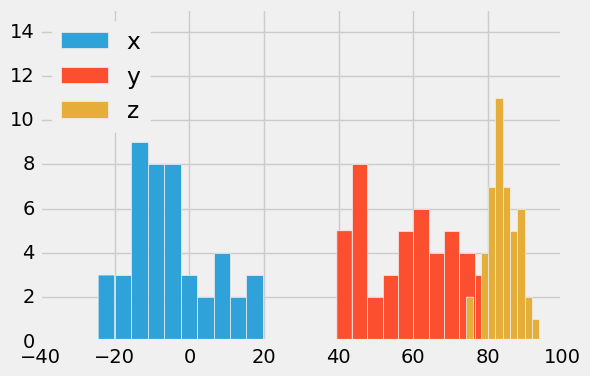

In [125]:
plt.hist(df.gx, label='x');
plt.hist(df.gy, label='y');
plt.hist(df.gz, label='z');
plt.legend(loc='upper left',);
plt.ylim(0,15)
print("mean position gx, gy, gz = {:.1f} {:.1f} {:.1f}".format(
    df.gx.mean(), df.gy.mean(), df.gz.mean()))
print("mean distance = {:.1f}".format(
    np.sqrt(df.gx**2+df.gy**2+df.gz**2).mean()))

In [126]:
dfBib

,bibcode,journal,title,year,volume,doi,hip_tyc_id
0,b'2009ApJS..181..444A',b'ApJS',b'X-ray-emitting stars identified from the ROS...,2009.0,181.0,b'10.1088/0067-0049/181/2/444',TYC 3850-257-1
1,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 63702
2,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',HIP 63702
3,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',TYC 4180-573-1
4,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',TYC 4180-573-1
5,b'1997PNAOJ...5....1Y',b'PNAOJ',b'The Tokyo PMC Catalog 90-93: Catalog of posi...,1997.0,5.0,b'',TYC 4180-573-1
6,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 66198
7,b'2012MNRAS.427..343M',b'MNRAS',b'Fundamental parameters and infrared excesses...,2012.0,427.0,b'10.1111/j.1365-2966.2012.21873.x',HIP 66198
8,b'2011MNRAS.411..435B',b'MNRAS',b'Bayesian inference of stellar parameters and...,2011.0,411.0,b'10.1111/j.1365-2966.2010.17699.x',HIP 66198
9,b'2012A&A...546A..61D',b'A&A',b'Radial velocities for the HIPPARCOS-Gaia Hun...,2012.0,546.0,b'10.1051/0004-6361/201219219',HIP 69275


In [133]:
simbad_tap_tablelist = mytap.get_table_list()
simbad_tap_tablelist[:3]

description,schema_name,table_name,table_type,utype
object,object,object,object,object
General data about an astronomical object,public,basic,table,
List of all object types associated with an object,public,otypes,table,
all names concatenated with pipe,public,ids,view,


In [139]:
simbad_tap_tablelist[simbad_tap_tablelist['table_name']==b'ident']

description,schema_name,table_name,table_type,utype
object,object,object,object,object
Identifiers of an astronomical object,public,ident,table,


In [142]:
mytap.get_table_info('ident')

id,oidref
object,int64


In [144]:
def query_identifiers(idstring):
    query = """
    -- Display all identifiers of a given object.
    SELECT id2.id
    FROM ident AS id1 JOIN ident AS id2 USING(oidref)
    WHERE id1.id = '{}';
    """.format(idstring)
    return mytap.query(query)

In [146]:
query_identifiers("80 Uma")

id
object
1RXS J132513.8+545920
2RXP J132513.9+545914
** SHY 248C
** PSF 1
NAME Alcor
PLX 3066
* 80 UMa
* g UMa
AG+55 887
